In [1]:
import random
import queue
import operator
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

N = 212
k = 10
r = 13
## older code which generated RRG from scratch 
# random.seed()

# adjList = [set() for i in range(N)]
# lmap = {}
# lcount = {}
# reverse_lmap = {}

# def generateRRG():
#     freePorts = N*r
#     lid = 0
#     iter = 0
#     while(freePorts > 1 and iter < 5*N*r):
#         iter += 1
#         available = [i for i in range(N) if len(adjList) != r]
#         tup = random.sample(available, 2)
#         s1 = tup[0]
#         s2 = tup[1]
#         # print s1, s2, freePorts, iter

#         # check for present link or unavailable free ports
#         if(s1 == s2):
#             continue
#         if(s1 in adjList[s2]):
#             continue
#         if(len(adjList[s1]) == r or len(adjList[s2]) == r):
#             continue

#         # Add link
#         lmap[(s1,s2)] = lid
#         lid+=1
#         adjList[s1].add(s2)
#         lmap[(s2, s1)] = lid
#         adjList[s2].add(s1)
#         lid+=1
#         freePorts = freePorts - 2

# # fills the adjlist
# generateRRG()
# k = [len(i) for i in adjList]
# k_ = sum(k)
# print k_
# while(k_ < N*r-1):
#     adjList = [set() for i in range(N)]
#     lmap = {}
#     generateRRG()
#     k = [len(i) for i in adjList]
#     k_ = sum(k)
#     print k_

# for i in lmap:
#     reverse_lmap[lmap[i]] = i

In [2]:
rrg = nx.random_regular_graph(r, N)

adjList = [set() for i in range(N)]
lmap = {}
lcount = {}
reverse_lmap = {}

lid = 0
for e in rrg.edges():
    lmap[e] = lid
    reverse_lmap[lid] = e
    lid += 1
    
    lmap[(e[1],e[0])] = lid
    reverse_lmap[lid] = (e[1], e[0])
    lid+=1

    adjList[e[0]].add(e[1])
    adjList[e[1]].add(e[0])

permute_traffic = np.random.permutation(N)

In [6]:
for i in lmap:
    lcount[lmap[i]] = 0

def run_bfs(switch, dst_switch, PATH_COUNT):
    visited = [False for i in range(N)]
    visited[switch] = True

    parents = [[] for i in range(N)]

    paths = [[] for i in range(N)]
    paths[switch]= [[switch]]

    level = {}
    level[switch] = 0

    q = queue.Queue()
    q.put(switch)

    # create bfs
    while(q.qsize() > 0):
        node = q.get()
        level_ = level[node]
        for child in adjList[node]:
            if visited[child] == False:
                q.put(child)
                parents[child].append(node)
                level[child] = level_+1
                visited[child] = True
                for n_paths in paths[node]:
                    paths[child].append(n_paths + [child])
            elif level[child] == level_ + 1: # multiple paths
                parents[child].append(node)
                for n_paths in paths[node]:
                    paths[child].append(n_paths + [child])

    for i in range(N):
        if i == switch or i != dst_switch:
            continue
        # select paths randomly for the ECMP routing
#         assert(set(paths[i]) == {p for p in nx.all_shortest_paths(rrg, switch, dst_switch)})
        paths[i] = random.sample(paths[i], min(len(paths[i]), PATH_COUNT))
#         assert(len(paths[i]) == min(len([p for p in nx.all_shortest_paths(rrg, switch, dst_switch)]), PATH_COUNT))
#         print switch, dst_switch, len(paths[i])
        for path in paths[i]:
            for i in range(1, len(path)):
                src = path[i-1]
                dst = path[i]
                assert(rrg.has_edge(src, dst))
                lcount[lmap[(src, dst)]] += 1


for i in range(N):
    run_bfs(i, permute_traffic[i], 8)


sorted_lcount = sorted(lcount.items(), key=operator.itemgetter(1))

plot_x8 = []
plot_y8 = []

for i in range(len(sorted_lcount)):
    plot_x8.append(i+1)
    plot_y8.append(sorted_lcount[i][1])

In [11]:
from eightshortestpaths import x,y

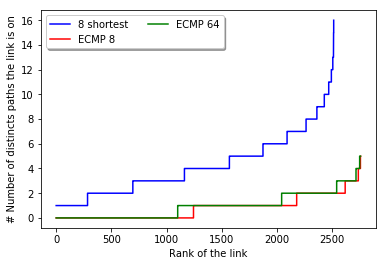

In [12]:
for i in lmap:
    lcount[lmap[i]] = 0

for i in range(N):
    run_bfs(i, permute_traffic[i], 64)


sorted_lcount = sorted(lcount.items(), key=operator.itemgetter(1))
# for i in sorted_lcount:
#     print i[1], reverse_lmap[i[0]]

plot_x64 = []
plot_y64 = []

for i in range(len(sorted_lcount)):
    plot_x64.append(i+1)
    plot_y64.append(sorted_lcount[i][1])

plt.plot(x, y, ls='solid', drawstyle='steps-post', label='8 shortest', color='blue')
plt.plot(plot_x8, plot_y8, ls='solid', drawstyle='steps-post', label='ECMP 8', color='red')
plt.plot(plot_x64, plot_y64, ls='solid', drawstyle='steps-post', label='ECMP 64', color='green')
plt.legend(loc='upper left', ncol=2, mode="shrink", shadow=True, fancybox=True)
plt.xlabel('Rank of the link')
plt.ylabel('# Number of distincts paths the link is on')
plt.savefig('fig%d.png'%(N,), bbox_inches='tight')
plt.show()